Setup: Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
warnings.filterwarnings('ignore')

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Rossmann")

# Load datasets
train = pd.read_csv("C:/Project-6/rossmann-store-sales/train.csv")
test = pd.read_csv("C:/Project-6/rossmann-store-sales/test.csv")
store = pd.read_csv("C:/Project-6/rossmann-store-sales/store.csv")

# Merge with store metadata
train = pd.merge(train, store, on="Store", how="left")
test = pd.merge(test, store, on="Store", how="left")

# Convert dates
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

logger.info(f"Train shape: {train.shape}, Test shape: {test.shape}")


INFO:Rossmann:Train shape: (1017209, 18), Test shape: (41088, 17)


In [2]:
print(train)
print(test)
print(store)

         Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a          

# Task 1: Exploration of Customer Purchasing Behavior

 Data Cleaning

In [2]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

EDA & Visualizations

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Promo Distribution')

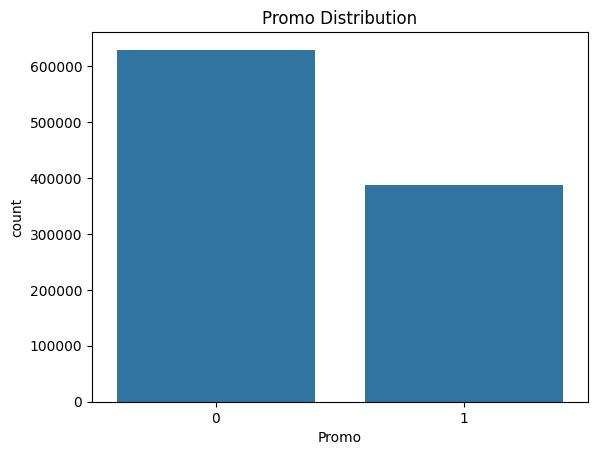

In [3]:
# Promo distribution
sns.countplot(data=train, x="Promo")
plt.title("Promo Distribution")

Text(0.5, 1.0, 'Sales vs Customers')

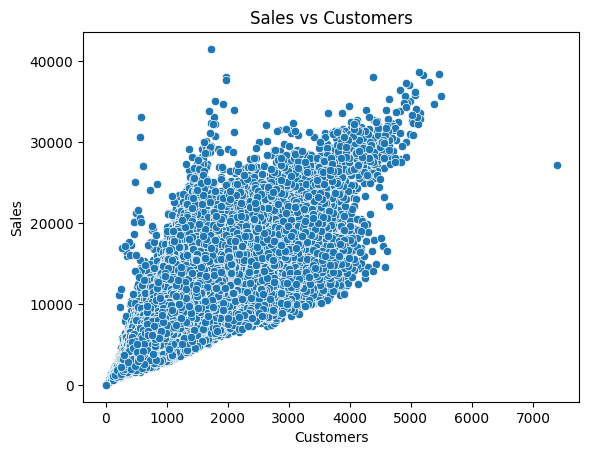

In [4]:
# Sales vs Customers
sns.scatterplot(x="Customers", y="Sales", data=train)
plt.title("Sales vs Customers")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Holiday vs Non-Holiday Sales')

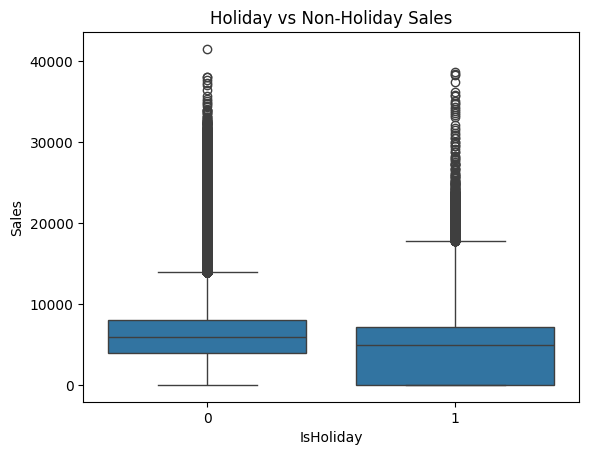

In [5]:
# Holiday sales comparison
train["IsHoliday"] = train["StateHoliday"].apply(lambda x: 0 if x == "0" else 1)
sns.boxplot(x="IsHoliday", y="Sales", data=train)
plt.title("Holiday vs Non-Holiday Sales")

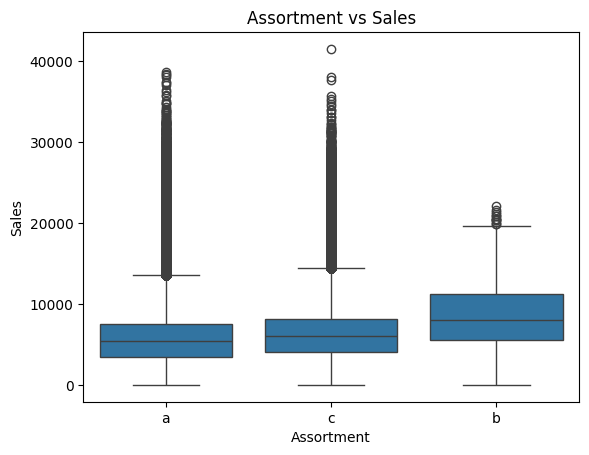

In [6]:
# Assortment impact
sns.boxplot(x="Assortment", y="Sales", data=train)
plt.title("Assortment vs Sales")
# Store open weekdays
open_days = train.groupby("Store")["DayOfWeek"].nunique()
full_week_stores = open_days[open_days == 7].index

# Task 2: Predicting Store Sales

Feature Engineering

In [ ]:
# Time-based features
for df in [train, test]:
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week

# Fix StateHoliday strings → integers
for df in [train, test]:
    df["StateHoliday"] = df["StateHoliday"].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3})
    df["StateHoliday"] = df["StateHoliday"].astype(int)

# Fill NA in numeric columns
numeric_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']
for col in numeric_cols:
    if col in train.columns:
        train[col] = train[col].fillna(0)
    if col in test.columns:
        test[col] = test[col].fillna(0)

# One-hot encoding
for col in ["StoreType", "Assortment"]:
    if col in train.columns:
        train = pd.get_dummies(train, columns=[col], drop_first=True)
    if col in test.columns:
        test = pd.get_dummies(test, columns=[col], drop_first=True)

# Align test and train
train, test = train.align(test, join="left", axis=1, fill_value=0)

# Final feature list used for modeling (matches Task 3)
feature_cols = ['Store', 'Promo', 'Customers', 'DayOfWeek', 'Month', 'Year', 'WeekOfYear',
                'SchoolHoliday', 'StateHoliday', 'CompetitionDistance'] + \
                [col for col in train.columns if "StoreType_" in col or "Assortment_" in col]

# Create feature matrix and target
X = train[feature_cols]
y = train["Sales"]

print("📋 Feature columns used:", feature_cols)

📋 Feature columns used: ['Store', 'Promo', 'Customers', 'DayOfWeek', 'Month', 'Year', 'WeekOfYear', 'SchoolHoliday', 'StateHoliday', 'CompetitionDistance', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c']


Modeling using Sklearn Pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

# Use sqrt of MSE to get RMSE
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 694.77


Serialize Model & MLflow Snippet

In [ ]:
import os
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from datetime import datetime
import joblib

# ✅ Define a safe MLflow tracking path
mlflow_path = "C:\Project-6\mlruns"  # ✅ No spaces in folder name
os.makedirs(mlflow_path, exist_ok=True)

# ✅ Set MLflow tracking URI
mlflow.set_tracking_uri(f"file:///{mlflow_path}")
mlflow.set_experiment("Rossmann Sales Forecasting")

# ✅ Create model save path
timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
os.makedirs("task2_models", exist_ok=True)
model_path = f"task2_models/sales_model_{timestamp}.pkl"

# ✅ Save (pipeline, features)
features = X_train.columns.tolist()
joblib.dump((pipeline, features), model_path, compress=3)
print("✅ Model saved to:", model_path)

# ✅ Define input example and signature for MLflow
input_example = X_train.iloc[:5]
signature = infer_signature(X_train, pipeline.predict(X_train))

# ✅ Log the model to MLflow with just the signature
with mlflow.start_run():
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="random_forest_model",
        signature=signature,  # ✅ log only the signature
        #pip_requirements=["scikit-learn==1.3.2", "cloudpickle==3.0.0"]
    )
    mlflow.log_metric("rmse", rmse)
    mlflow.log_param("model_type", "RandomForest")

print("✅ Model logged to MLflow.")

2025/04/15 13:57:33 INFO mlflow.tracking.fluent: Experiment with name 'Rossmann Sales Forecasting' does not exist. Creating a new experiment.


✅ Model saved to: task2_models/sales_model_15-04-2025-13-57-33.pkl
✅ Model logged to MLflow.


✅ Run MLflow UI

Once model is logged, you can view the MLflow dashboard:

Run blow given command in Terminal

mlflow ui --backend-store-uri file:///C:/Project-6/mlruns

Then go to:
http://127.0.0.1:5000

Feature Importance

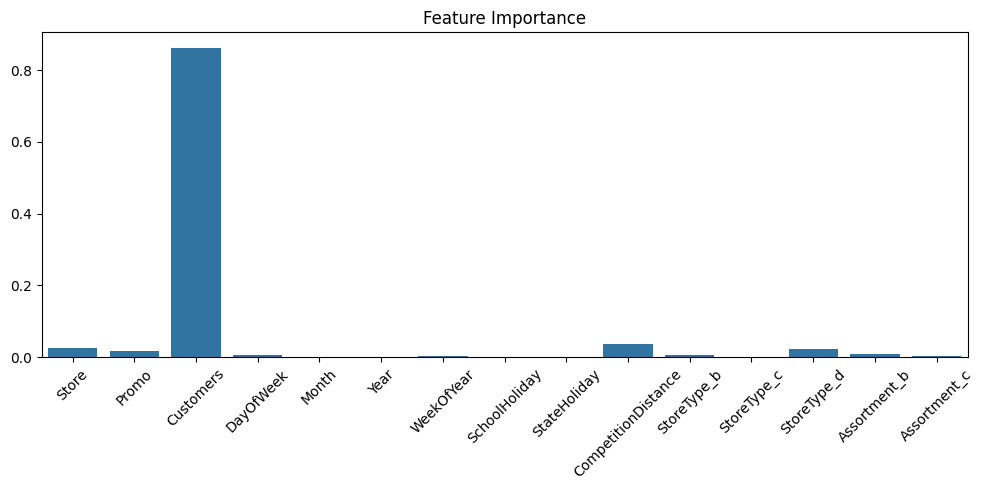

In [ ]:
rf = pipeline.named_steps["model"]
importances = rf.feature_importances_

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_cols, y=importances)
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.tight_layout()

Deep Learning (LSTM) for Sales Forecasting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Time series on one store
store_1_sales = train[train["Store"] == 1][["Sales"]].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(store_1_sales)

def create_dataset(series, look_back=7):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_dataset(scaled)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

model = Sequential([
    LSTM(50, activation='relu', input_shape=(7, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=16)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2004
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1718
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1545
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1452
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1260
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1022
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0990
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0898
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0836


# Task 3: Serving with Streamlit 

In [23]:
import os
from glob import glob
import joblib

# Load most recent model from folder
model_dir = "task2_models"  # replace with your folder if different
model_files = glob(f"{model_dir}/sales_model_*.pkl")

if not model_files:
    raise FileNotFoundError("No model found in task2_models/")

latest_model_path = max(model_files, key=os.path.getctime)
print("✅ Loading model:", latest_model_path)

loaded_model = joblib.load(latest_model_path)

✅ Loading model: task2_models\sales_model_15-04-2025-13-57-33.pkl


After run Task 3 please run app.py 

for run app.py please run below given command in terminal:

streamlit run app.py

Then go to: http://localhost:8501